# QUBO建模及矩阵构建

In [1]:
import time
import numpy as np
import csv

In [2]:
# --------------------------参数设置（对应论文）--------------------------
# 空间与时间维度参数
M, N = 8, 8  # 超表面空间行数、列数（m:0~M-1, n:0~N-1）
L = 4  # 时间编码序列长度（l:0~L-1）
n_bit = 2  # 相位编码比特数（1或2）
h = 0  # 目标谐波阶数（h=0对应中心频率）
# 波束方向参数
theta0, phi0 = np.deg2rad(-14.5), 0  # 主波束方向（θ, φ）
theta_main_low = theta0 - 0.1  # 主波束区域下界（弧度）
theta_main_high = theta0 + 0.1  # 主波束区域上界（弧度）
theta_side = np.linspace(-np.pi / 2, np.pi / 2, 20)  # 旁瓣离散角度（积分近似）
# 权重参数（平衡主波束与旁瓣）
w_main = 10.0  # 主波束增强权重
w_side = -1.0  # 旁瓣抑制权重（负值表示惩罚）
# 物理参数（归一化）
lambda0 = 1.0  # 波长
k0 = 2 * np.pi / lambda0  # 自由空间波数
d = lambda0 / 2  # 超原子间距（λ/2，满足Nyquist采样）
# 2比特编码系数（满足|c1|² + |c2|² = 1
c = [1.0 / np.sqrt(2), np.exp(1.0j*np.pi/2)/ np.sqrt(2)]
# 总超原子数与总变量数计算
total_atoms = M * N * L  # 空间×时间超原子总数
total_spins = total_atoms * n_bit  # QUBO变量总数（每个超原子n_bit个变量）
print(f"总变量数：{total_spins}（需≤550以适配CIM）")
start_time = time.time()  # 记录开始时间

总变量数：512（需≤550以适配CIM）


In [3]:
# --------------------------1. 索引解析函数--------------------------
def parse_index(p):
    """
    将QUBO变量索引p解析为物理参数：
    输出：(m, n, l, b)
        m: 空间行索引（0~M-1）
        n: 空间列索引（0~N-1）
        l: 时间槽索引（0~L-1）
        b: 比特索引（0~n_bit-1）
    索引规则：p = atom_idx * n_bit + b，其中atom_idx = m*(N*L) + n*L + l
    """
    atom_idx = p // n_bit  # 超原子索引（剥离比特维度）
    b = p % n_bit  # 比特索引（0~n_bit-1）
    # 解析超原子的空间-时间索引（atom_idx = m*(N*L) + n*L + l）
    l = atom_idx % L
    rem_after_l = atom_idx // L  # 剩余部分：m*N + n
    n = rem_after_l % N
    m = rem_after_l // N

    return m, n, l, b

In [4]:
# --------------------------2. 耦合系数A计算--------------------------
def compute_A(m_p, n_p, l_p, m_q, n_q, l_q, theta, phi):
    """计算特定方向(theta, phi)的耦合系数A_pq^h（论文式52）"""
    # 波数分量
    kx = k0 * np.sin(theta) * np.cos(phi)
    ky = k0 * np.sin(theta) * np.sin(phi)
    # 空间相位差
    spatial_phase = kx * (m_p - m_q) * d + ky * (n_p - n_q) * d
    # 时间相位差
    temporal_phase = -2 * np.pi * h * (l_p - l_q) / L
    # Sinc调制因子
    if h == 0:
        sinc_sq = 1.0  # sinc(0) = 1
    else:
        sinc_val = np.sin(np.pi * h / L)
        sinc_sq = (sinc_val / (np.pi * h / L)) ** 2
    # 单个超原子的远场方向图（论文假设为余弦分布）
    E_sq = np.cos(theta)
    A = (E_sq**2 / (L ** 2)) * sinc_sq * np.exp(1j * (spatial_phase + temporal_phase))
    return A

In [5]:
# --------------------------3. 物理耦合系数J矩阵计算（含主波束+旁瓣）--------------------------
print("步骤1/3：计算物理耦合系数J矩阵...")
# 初始化J矩阵
J_phys = np.zeros((total_spins, total_spins), dtype=np.float64)

for p in range(total_spins):
    m_p, n_p, l_p, b_p = parse_index(p)

    for q in range(p, total_spins):  # 利用对称性，仅计算上三角
        m_q, n_q, l_q, b_q = parse_index(q)

        # 3.1 计算主波束耦合系数A_main
        A_main = compute_A(m_p, n_p, l_p, m_q, n_q, l_q, theta0, phi0)

        # 3.2 计算旁瓣区域平均耦合系数A_side（积分近似）
        A_side_sum = 0.0
        side_count = 0
        for ths in theta_side:
            if not (theta_main_low < ths < theta_main_high):  # 排除主波束
                A_ths = compute_A(m_p, n_p, l_p, m_q, n_q, l_q, ths, 0)
                A_side_sum += A_ths
                side_count += 1
        A_side = A_side_sum / side_count if side_count > 0 else 0.0

        # 3.3 总耦合系数A_total = 主波束项 + 旁瓣项
        A_total = w_main * A_main + w_side * A_side

        # 3.4 计算自旋模型耦合系数J（区分1比特/2比特）
        if n_bit == 1:
            # 1比特：J_pq = Re(A_total)
            J_val = np.real(A_total)
        else:
            # 2比特：J_ab^pq = Re(c[b_p] * conj(c[b_q]) * A_total)
            J_val = np.real(c[b_p] * np.conj(c[b_q]) * A_total)

        # 3.5 对称赋值（J_phys[p,q] = J_phys[q,p]）
        J_phys[p, q] = J_val
        if p != q:
            J_phys[q, p] = J_val

步骤1/3：计算物理耦合系数J矩阵...


In [6]:
# --------------------------4. QUBO矩阵计算（严格应用映射公式）--------------------------
print("步骤2/3：将J矩阵转换为QUBO矩阵...")
qubo = np.zeros((total_spins, total_spins), dtype=np.float64)

for p in range(total_spins):
    # 4.1 计算线性项系数a_p（对角项）
    # 公式：a_p = 4 * sum(J_phys[p,q] for q in all if q != p)
    sum_j = 0.0
    for q in range(total_spins):
        if q != p:
            sum_j += J_phys[p, q]
    a_p = 4 * sum_j  # 线性项系数（1比特/2比特通用）
    qubo[p, p] = a_p  # 对角项存储线性项

    # 4.2 计算二次项系数b_pq（非对角项，p < q）
    for q in range(p + 1, total_spins):  # 仅计算上三角非对角项
        # 公式：b_pq = -8 * J_phys[p,q]（1比特/2比特通用）
        b_pq = -8 * J_phys[p, q]
        qubo[p, q] = b_pq
        qubo[q, p] = b_pq  # 对称赋值

步骤2/3：将J矩阵转换为QUBO矩阵...


In [7]:
# --------------------------5. 矩阵缩放与导出（适配硬件要求）--------------------------
print("步骤3/3：缩放矩阵并导出...")
# 手动缩放矩阵以适配int8范围
max_abs_val = np.max(np.abs(qubo))
if max_abs_val > 0:
    scale_factor = 127.0 / max_abs_val
    print(f"应用缩放因子: {scale_factor:.6f} (最大绝对值: {max_abs_val:.4f})")
    qubo_scaled = np.round(qubo * scale_factor).astype(np.int8)
else:
    qubo_scaled = np.zeros_like(qubo, dtype=np.int8)

with open('qubo_matrix_complete.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for row in qubo_scaled:
        writer.writerow(row)


end_time = time.time()
total_time = end_time - start_time
minutes = int(total_time // 60)
seconds = total_time % 60
# 验证输出信息
print("\nQUBO矩阵生成完成，参数验证：")
print(f"- 矩阵维度：{qubo_scaled.shape[0]}×{qubo_scaled.shape[1]}")
print(f"- 数值范围：[{np.min(qubo_scaled)}, {np.max(qubo_scaled)}]")
print(f"- 数据类型：{qubo_scaled.dtype}")
print(f"- 非零元素占比：{np.count_nonzero(qubo_scaled) / (total_spins ** 2):.2%}")
print(f"- 导出路径：qubo_matrix_complete.csv")
print(f"- 主程序执行时间：{minutes}分{seconds:.2f}秒")  #jupyter netbook 中运行时间会比本地运行时间长很多，这里的运行时间仅作参考

步骤3/3：缩放矩阵并导出...
应用缩放因子: 29.937447 (最大绝对值: 4.2422)

QUBO矩阵生成完成，参数验证：
- 矩阵维度：512×512
- 数值范围：[-127, 71]
- 数据类型：int8
- 非零元素占比：78.12%
- 导出路径：qubo_matrix_complete.csv
- 主程序执行时间：0分30.10秒


# 真机求解结果（最优解）

[{"result": 0, "quboValue": -1952576, "solutionVector": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

# 解码及可视化

In [8]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

matplotlib.rcParams["font.family"] = ["SimHei"]
matplotlib.rcParams['axes.unicode_minus'] = False

In [9]:
# --------------------------参数设置（与建模代码一致）--------------------------
# 空间与时间维度参数
M, N = 8, 8  # 超表面空间行数、列数
L = 4  # 时间编码序列长度
n_bit = 2  # 相位编码比特数（1或2）
h = 0  # 目标谐波阶数

# 波束方向参数
theta0, phi0 = np.deg2rad(-14.5), 0  # 主波束目标方向
target_theta_deg = np.rad2deg(theta0)  # 目标角度（度）

# 物理参数
lambda0 = 1.0  # 波长
k0 = 2 * np.pi / lambda0  # 自由空间波数
d = lambda0 / 2  # 超原子间距（λ/2）

# 2比特编码系数（1bit系数为1，不显示）
c = [1.0 / np.sqrt(2), np.exp(1.0j*np.pi/2) / np.sqrt(2)]

# 总变量数（与建模代码一致）
total_atoms = M * N * L
total_spins = total_atoms * n_bit  # QUBO变量总数

In [10]:
# --------------------------1. 索引解析函数--------------------------
def parse_index(p):
    """与建模代码parse_index完全一致，确保索引映射统一"""
    atom_idx = p // n_bit  # 超原子索引（剥离比特维度）
    b = p % n_bit  # 比特索引（0~n_bit-1）

    # 解析超原子的空间-时间索引（atom_idx = m*(N*L) + n*L + l）
    l = atom_idx % L
    rem_after_l = atom_idx // L
    n = rem_after_l % N
    m = rem_after_l // N

    return m, n, l, b

In [11]:
# --------------------------2. 相位解码函数--------------------------
def decode_solution(qubo_solution):
    """根据建模代码的编码规则解码相位"""
    phase = np.zeros((M, N, L), dtype=np.complex128)
    for p in range(total_spins):
        m, n, l, b = parse_index(p)
        x = qubo_solution[p]
        s = 2 * x - 1  # 自旋变量映射（0→-1，1→+1）
        phase[m, n, l] += c[b] * s
    phase /= np.abs(phase)
    return phase

In [12]:
# --------------------------3. 远场功率计算--------------------------
def calc_far_field(phase, h=0):
    """根据建模代码的耦合系数A计算逻辑，计算远场功率"""
    theta_range = np.linspace(-np.pi / 2, np.pi / 2, 720)  # 角度范围：-90°到90°
    P = np.zeros_like(theta_range)

    for idx, theta in enumerate(theta_range):
        # 波数分量
        kx = k0 * np.sin(theta) * np.cos(phi0)
        ky = k0 * np.sin(theta) * np.sin(phi0)
        E_total = 0j

        for m in range(M):
            for n in range(N):
                for l in range(L):
                    # 空间相位
                    spatial_phase = kx * m * d + ky * n * d
                    # 时间相位
                    temporal_phase = -2 * np.pi * h * l / L
                    E_total += phase[m, n, l] * np.exp(1j * (spatial_phase + temporal_phase))

        # 功率计算
        if h == 0:
            sinc_sq = 1.0
        else:
            sinc_val = np.sin(np.pi * h / L)
            sinc_sq = (sinc_val / (np.pi * h / L)) ** 2
        # 远场方向图
        E_sq = np.cos(theta) ** 2
        P[idx] = np.abs(E_total) ** 2 * sinc_sq * E_sq / (L ** 2)

    return theta_range, P

In [13]:
if __name__ == "__main__":
    # 输入最优解（QUBO解）
    qubo_solution = np.array(
        [ 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
          1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
          0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
          0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
          0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
          1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
          1, 0, 1, 0, 1, 0, 1, 0 ]
    )
    # 修正解长度
    if len(qubo_solution) < total_spins:
        qubo_solution = np.pad(qubo_solution, (0, total_spins - len(qubo_solution)), mode='constant')
    elif len(qubo_solution) > total_spins:
        qubo_solution = qubo_solution[:total_spins]
    print(f"QUBO解长度：{len(qubo_solution)}（应等于{total_spins}）")

    # 解码相位
    phase = decode_solution(qubo_solution)
    print(f"相位解码完成，维度：(M, N, L,n-bit) = {(M, N, L,n_bit)}")

    # 相位离散值验证
    phase_angles = np.angle(phase) % (2 * np.pi)  # 归一化到[0, 2π)
    phase_normalized = np.round(phase_angles / np.pi, 2)
    unique_phases = np.unique(phase_normalized)
    print(f"相位离散值验证：{unique_phases}π rad")

    # 计算远场功率
    theta_range, P_raw = calc_far_field(phase, h=h)
    theta_deg = np.rad2deg(theta_range)
    max_power = np.max(P_raw)  # 以主瓣功率为基准归一化
    P = P_raw / max_power
    P_dB = 10 * np.log10(P + 1e-10)

    # 4.1 主瓣定位（全局最大功率点）
    peak_idx = np.argmax(P_raw)
    mainlobe_theta = theta_deg[peak_idx]
    main_power = P[peak_idx]  # 应为1.0

    # 4.2 旁瓣抑制比（SLL）
    main_theta_rad = theta_range[peak_idx]
    # 排除主瓣±5°范围（与建模代码的主波束区域逻辑一致）
    sidelobe_mask = np.abs(theta_range - main_theta_rad) > np.deg2rad(40)
    sidelobe_power = np.max(P[sidelobe_mask]) if np.any(sidelobe_mask) else 0
    sll = 10 * np.log10(sidelobe_power / main_power) if main_power > 0 else -np.inf

    # 4.3 角度误差（与建模目标角度对比）
    angle_error = np.abs(mainlobe_theta - target_theta_deg)

    # 4.4 3dB波束宽度
    peak_power_dB = P_dB[peak_idx]
    half_power_dB = peak_power_dB - 3
    # 左侧3dB点
    left_mask = (theta_range < main_theta_rad) & (P_dB <= half_power_dB)
    left_idx = np.where(left_mask)[0]
    left_3db = theta_deg[left_idx[-1]] if len(left_idx) > 0 else theta_deg[0]
    # 右侧3dB点
    right_mask = (theta_range > main_theta_rad) & (P_dB <= half_power_dB)
    right_idx = np.where(right_mask)[0]
    right_3db = theta_deg[right_idx[0]] if len(right_idx) > 0 else theta_deg[-1]
    beamwidth_3db = right_3db - left_3db

    # 打印评估结果
    print("\n=== 性能评估结果 ===")
    print(f"主瓣功率（归一化）：{main_power:.2f}")
    print(f"旁瓣最大值（归一化）：{sidelobe_power:.4f}")
    print(f"旁瓣抑制比（SLL）：{sll:.2f} dB")
    print(f"主瓣角度(°)：{mainlobe_theta:.2f}")
    print(f"目标角度(°)：{target_theta_deg:.2f}")
    print(f"角度误差(°)：{angle_error:.2f}")
    print(f"3dB波束宽度(°)：{beamwidth_3db:.2f}")

    # 4.5 谐波抑制评估（与建模代码的h=0目标对比）
    harmonics = [-2, -1, 1, 2]
    harmonic_suppression = []
    for h_harm in harmonics:
        _, P_harm_raw = calc_far_field(phase, h=h_harm)
        # 提取谐波在主瓣角度处的功率
        harm_power = P_harm_raw[peak_idx]
        # 抑制比 = 10*log10(谐波功率 / 主瓣功率)
        suppression = 10 * np.log10((harm_power / max_power) + 1e-10)
        harmonic_suppression.append(suppression)

    print("\n=== 非目标谐波抑制（dB） ===")
    for h_harm, supp in zip(harmonics, harmonic_suppression):
        print(f"h={h_harm}: {supp:.2f} dB")


QUBO解长度：512（应等于512）
相位解码完成，维度：(M, N, L,n-bit) = (8, 8, 4, 2)
相位离散值验证：[0.25 0.75 1.25 1.75]π rad

=== 性能评估结果 ===
主瓣功率（归一化）：1.00
旁瓣最大值（归一化）：0.0846
旁瓣抑制比（SLL）：-10.72 dB
主瓣角度(°)：-14.90
目标角度(°)：-14.50
角度误差(°)：0.40
3dB波束宽度(°)：13.27

=== 非目标谐波抑制（dB） ===
h=-2: -100.00 dB
h=-1: -100.00 dB
h=1: -100.00 dB
h=2: -100.00 dB


## 可视化

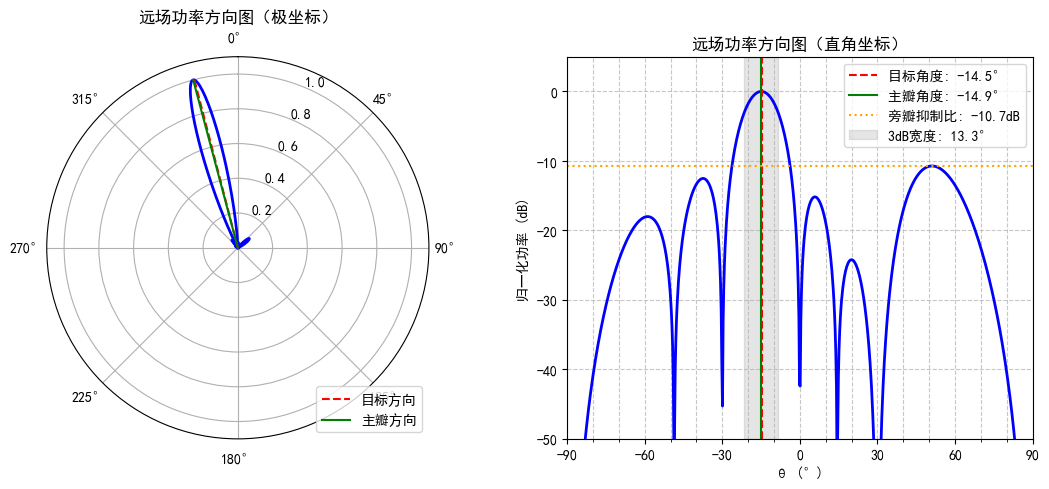

In [14]:
    fig = plt.figure(figsize=(11, 5))

    # 极坐标图
    ax1 = plt.subplot(121, polar=True)
    ax1.plot(theta_range, P, 'b-', linewidth=2)
    ax1.set_theta_zero_location('N')
    ax1.set_theta_direction(-1)
    ax1.set_ylim(0, 1.1)
    ax1.set_title('远场功率方向图（极坐标）')
    ax1.plot([theta0, theta0], [0, 1], 'r--', label='目标方向')
    ax1.plot([theta_range[peak_idx], theta_range[peak_idx]], [0, 1], 'g-', label='主瓣方向')
    ax1.legend(loc='lower right')

    # 直角坐标图
    ax2 = plt.subplot(122)
    ax2.plot(theta_deg, P_dB, 'b-', linewidth=2)
    ax2.axvline(x=target_theta_deg, color='red', linestyle='--', label=f'目标角度: {target_theta_deg:.1f}°')
    ax2.axvline(x=mainlobe_theta, color='green', linestyle='-', label=f'主瓣角度: {mainlobe_theta:.1f}°')
    ax2.axhline(y=sll, color='orange', linestyle=':', label=f'旁瓣抑制比: {sll:.1f}dB')
    ax2.axvspan(left_3db, right_3db, color='gray', alpha=0.2, label=f'3dB宽度: {beamwidth_3db:.1f}°')

    ax2.set_xlabel('θ (°)')
    ax2.set_ylabel('归一化功率 (dB)')
    ax2.set_title('远场功率方向图（直角坐标）')
    ax2.set_xlim(-90, 90)
    ax2.set_ylim(-50, 5)
    ax2.xaxis.set_major_locator(MultipleLocator(30))
    ax2.xaxis.set_minor_locator(MultipleLocator(10))
    ax2.grid(which='both', linestyle='--', alpha=0.7)
    ax2.legend()

    plt.tight_layout()
    plt.show()